source : https://www.kaggle.com/chirag19/air-passengers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### The dataset

In [3]:
dataset = pd.read_csv('AirPassengers.csv', delimiter =',', encoding='latin-1', dtype = object)
dataset = pd.DataFrame(dataset)
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset.shape

(144, 2)

In [5]:
timeseries = dataset.values

#### The "time-delayed" Hankel matrix

In [6]:
h = 1   # time steps
n = 134
l = 10   # length of observations (rows) taken into account for each row of the Hankel matrix
H = np.zeros((n,l))
for i in range(n): 
        H[i,:] = timeseries[i*h:i*h+l,1]

print(H.shape)

(134, 10)


In [7]:
u,s,v = np.linalg.svd(H)

<IPython.core.display.Javascript object>


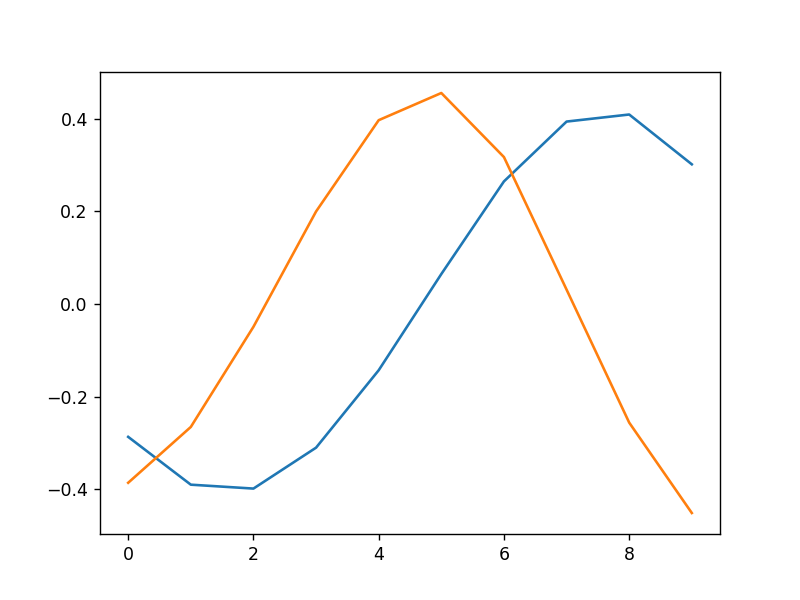

In [8]:
%matplotlib notebook
plt.plot(np.arange(v.shape[0]),v[1,:])
plt.plot(np.arange(v.shape[0]),v[2,:])

Remark :

We observe that the graph of the principal components tends to become sinusoidal. This is an indication that the underlying dynamical system is "close" to become a linear dynamical system.

Consequently, we can now use the DMD algorithm to determine the dmd modes of the system. Then we use them to make predictions for the future behaviour of the model.

#### The "dmd" and the "time evolution" functions

In [9]:
def dmd (A,r):
    """
    A : data-matrix, snapshots of a "linear" dynamical system
    Phi : the dmd modes
    """
    
    X = A[:,:-1]
    Y = A[:,1:]
    
    u,s,v = np.linalg.svd(X)
    U = u[:,:r]
    S = np.diag(s)[:r,:r]
    V = np.conjugate(v).T[:,:r]
    
    Atil = (((np.conjugate(U).T@Y)@V)@np.linalg.inv(S))
    mu,W = np.linalg.eig(Atil)

    Phi = (((Y@V)@np.linalg.inv(S))@ W) 
    
    b = ((np.linalg.pinv(Phi))@X[:,0])
    
    return mu, Phi, b

In [10]:
def time_evolution (A,r,f):
    """
    f : future time steps 
    """
    t = np.arange(A.shape[1]+f)
    
    Psi = np.zeros((r, t.size), dtype='complex')
    for i,_t in enumerate(t):
        Psi[:,i] = (dmd(A,r)[0]**_t)*dmd(A,r)[2]
    E = dmd(A,r)[1]@Psi
    
    return E

#### The prediction

In [11]:
np.sum(s[:6])/np.sum(s)

0.958049739777721

In [12]:
D = time_evolution(H,6,1) # We predict one step ahead in the future (f = 1)

In [13]:
D.shape

(134, 11)

The prediction is :

In [14]:
D.real[-1,:]

array([419.1652817 , 430.24239189, 444.91464617, 495.26989883,
       564.31969831, 594.94821598, 555.75648037, 476.61196531,
       417.20829179, 408.93622018, 434.39356124])

In [15]:
D.real[-1,:][-1]

434.393561244142

The last 10 real values are :

In [16]:
timeseries[134:144,1]

array(['419', '461', '472', '535', '622', '606', '508', '461', '390',
       '432'], dtype=object)